# Grid Search e KNN

Sua missão é aplicar o algoritmo KNN nos dados explorados durante o curso e efetuar a otimização de hiperparâmetros com o auxílio do GridSearchCV. Além disso, faça a análise dos resultados obtidos.

Para fazer essa otimização utilize a seguinte grade de hiperparâmetros

```python
param_grid_knn = {
    'n_neighbors': linspace(5, 25, 10, dtype=int),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
```

In [1]:
from numpy import linspace

param_grid_knn = {
    'knn__n_neighbors': linspace(5, 25, 10, dtype=int),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

In [2]:
import pandas as pd

df = pd.read_csv('dados_inadimplencia.csv')
df.head()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,16855.246324,2997.000000,12.157324,0,2.0,0.501213,0.003109,0.513171,0.117428,243.0,1
1,13500.000000,2776.050000,12.157324,0,2.0,0.501213,0.269730,0.513171,0.097900,617.0,0
2,11250.000000,2722.188351,12.157324,0,3.0,0.701396,0.518625,0.700184,0.118600,9.0,0
3,27000.000000,6750.000000,3.000000,0,2.0,0.501213,0.649571,0.513171,0.047400,300.0,0
4,22500.000000,3097.800000,12.157324,0,2.0,0.440744,0.509677,0.513171,0.014400,2913.0,1


In [3]:
X = df.drop('inadimplente', axis=1)
y = df['inadimplente']

In [4]:
RANDOM_STATE = 42

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, stratify=y, random_state=RANDOM_STATE)

## KNN valores default

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score

pipe_knc = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
pipe_knc.fit(X_train, y_train)
print(f'Recall para KNN sem otimizações: {recall_score(y_test, pipe_knc.predict(X_test)):.3f}')

Recall para KNN sem otimizações: 0.343


## Encontrando melhores valores de hiperparâmetros com `GridSearchCV`

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(
    estimator=pipe_knc,
    param_grid=param_grid_knn,
    scoring='recall',
    cv=cv
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': array([ 5,  7,  9, 11, 13, 16, 18, 20, 22, 25]),
                         'knn__weights': ['uniform', 'distance']},
             scoring='recall')

In [8]:
grid_search.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}

In [9]:
knc_grid_cv_results = pd.DataFrame(grid_search.cv_results_).loc[[grid_search.best_index_]]
print(f'Recall médio da validação cruzada em KNN otimizado: {knc_grid_cv_results["mean_test_score"].item():.3f}')

Recall médio da validação cruzada em KNN otimizado: 0.366


## KNN otimizado

In [10]:
pipe_knc_optimized = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(metric='manhattan', weights='distance'))
])
pipe_knc_optimized.fit(X_train, y_train)
print(f'Recall para KNN otimizado: {recall_score(y_test, pipe_knc_optimized.predict(X_test)):.3f}')

Recall para KNN otimizado: 0.391


## Resultados

Recall para KNN sem otimizações: 0.343

Recall médio da validação cruzada em KNN otimizado:  0.366

**Recall para KNN otimizado: 0.391**

              precision    recall  f1-score   support

  Adimplente       0.73      0.79      0.76      3255
Inadimplente       0.47      0.39      0.43      1556

    accuracy                           0.66      4811
   macro avg       0.60      0.59      0.59      4811
weighted avg       0.65      0.66      0.65      4811



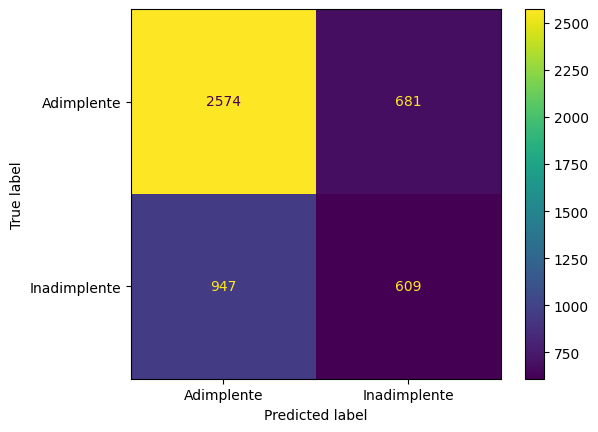

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
print(classification_report(y_test, pipe_knc_optimized.predict(X_test), target_names=['Adimplente', 'Inadimplente']))
ConfusionMatrixDisplay.from_predictions(y_test, pipe_knc_optimized.predict(X_test), display_labels=['Adimplente', 'Inadimplente']);

## Análise gráfica

Analisando como o valor de cada hiperparâmetro afeta a métrica de recall.

In [12]:
grid_cv_results = pd.DataFrame(grid_search.cv_results_)
grid_cv_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023993,0.009209,0.410798,0.027246,euclidean,5,uniform,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",0.327532,0.324367,0.363924,0.324367,0.294304,0.326899,0.02212,10


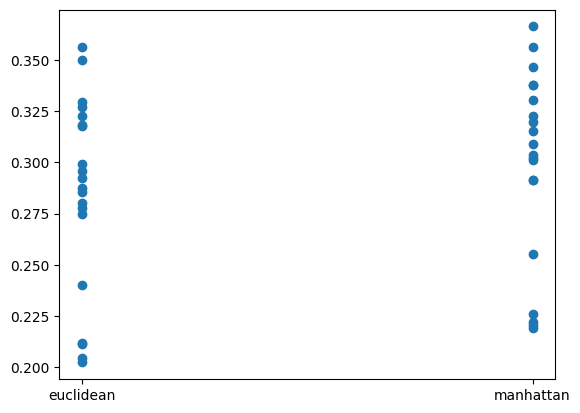

In [13]:
import matplotlib.pyplot as plt

plt.scatter(grid_cv_results['param_knn__metric'], grid_cv_results['mean_test_score'])
plt.show()

A distância Manhattan apresentou um valor de recall um pouco melhor em uma das validações.

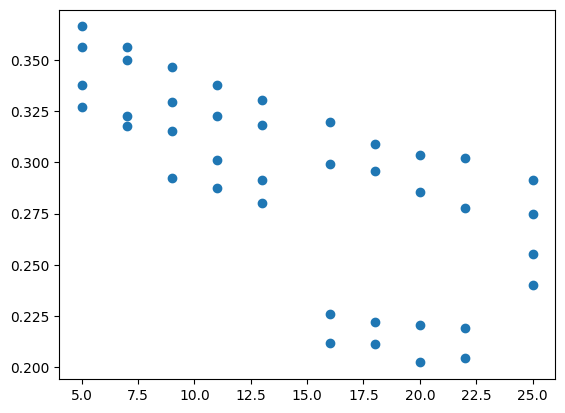

In [14]:
plt.scatter(grid_cv_results['param_knn__n_neighbors'], grid_cv_results['mean_test_score'])
plt.show()

O aumento no número de vizinhos mostra uma tendência a piorar o recall.

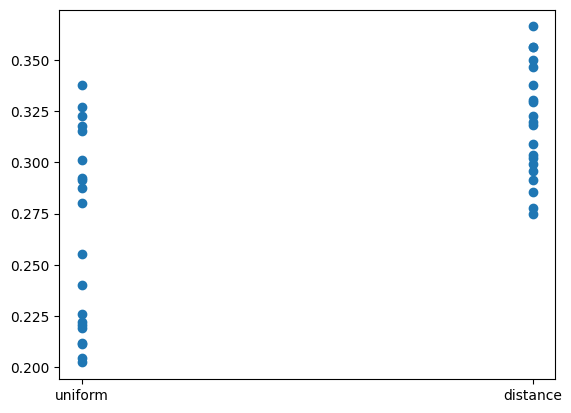

In [15]:
plt.scatter(grid_cv_results['param_knn__weights'], grid_cv_results['mean_test_score'])
plt.show()

Utilizar a distância como função de peso apresenta melhores resultados do que pesos uniformes.

## Otimização Bayesiana e KNN

Chegou a hora de aplicarmos outra técnica de otimização a esse modelo.

Sua tarefa agora é aplicar os conhecimentos adquiridos de otimização bayesiana ao KNN.

In [16]:
from skopt.space import Integer, Categorical
from skopt import BayesSearchCV

inner_cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(shuffle=True, random_state=RANDOM_STATE, n_splits=3)

search_spaces = {
    'knn__n_neighbors': Integer(5, 25),
    'knn__weights': Categorical(['uniform', 'distance']),
    'knn__metric': Categorical(['euclidean', 'manhattan'])
}

model_bayes = BayesSearchCV(
    estimator=pipe_knc,
    search_spaces=search_spaces,
    n_iter=50, # the bigger, the longer it takes to run
    scoring='recall',
    cv=inner_cv,
    random_state=42
)

In [17]:
from sklearn.model_selection import cross_val_score

nested_cv_scores = cross_val_score(model_bayes, X_train, y_train, cv=outer_cv)

c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warni

In [18]:
print(f'Recall médio da validação cruzada aninhada com otimização bayesiana: {nested_cv_scores.mean():.3f}')

Recall médio da validação cruzada aninhada com otimização bayesiana: 0.367


O recall médio foi de 0.367, ligeiramente melhor do que o obtido no Grid Search (0.366). No entanto, também temos que levar em conta que a métrica do Grid Search foi obtida sem a validação cruzada aninhada, então deve estar com um valor mais otimista. 

Vamos verificar os melhores parâmetros que o modelo encontra com os dados de treino:

In [19]:
model_bayes.fit(X_train, y_train)
model_bayes.best_params_

c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\codes\ML-classificacao-Alura\venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warni

OrderedDict([('knn__metric', 'manhattan'),
             ('knn__n_neighbors', 6),
             ('knn__weights', 'distance')])

Diferente do que foi encontrado com o Grid Search, a otimização Bayesiana definiu que o valor de n_neighbors é 6. Os valores para os outros hiperparâmetros foi igual.

Vamos treinar o modelo com esses hiperparâmetros e avaliá-lo:

Recall para KNN com otimização Bayesiana: 0.376
              precision    recall  f1-score   support

  Adimplente       0.73      0.80      0.76      3255
Inadimplente       0.47      0.38      0.42      1556

    accuracy                           0.66      4811
   macro avg       0.60      0.59      0.59      4811
weighted avg       0.65      0.66      0.65      4811



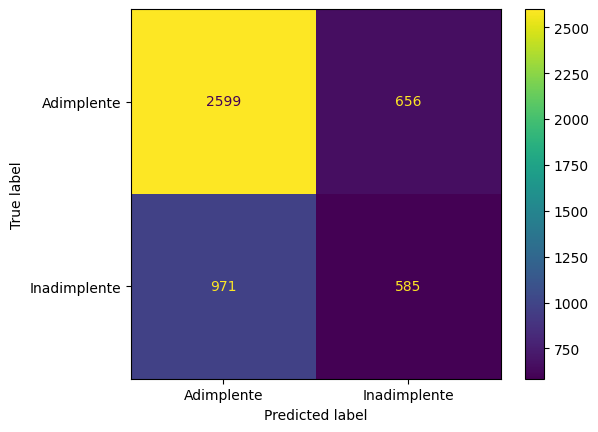

In [20]:
model_bayes_optimized = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=6, metric='manhattan', weights='distance'))
])
model_bayes_optimized.fit(X_train, y_train)
y_predict = model_bayes_optimized.predict(X_test)

print(f'Recall para KNN com otimização Bayesiana: {recall_score(y_test, y_predict):.3f}')
print(classification_report(y_test, y_predict, target_names=['Adimplente', 'Inadimplente']))
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels=['Adimplente', 'Inadimplente']);

Na avaliação final, os hiperparâmetros encontrados com o **Grid Search** se mostraram **melhores**, apesar de ser uma melhoria super pequena. Ainda assim, o tempo de execução do Grid Search para essa base de dados foi muito menor do que o da otimização Bayesiana.